<a href="https://colab.research.google.com/github/semensorokin/data_augmetation/blob/master/BertTrecAugmentationWithVectorsCheckAllSpans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/UniversalEmb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/UniversalEmb


In [2]:
import pandas as pd
n_examples = 6000

labels = [i.split(' ', 1 )[0].split(':')[1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
texts = [ i.split(' ', 1 )[1][:-1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
train  = pd.DataFrame({'texts':texts, 'labels': labels})

labels_t = [i.split(' ', 1)[0].split(':')[1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
test  = pd.DataFrame({'texts':texts_t, 'labels': labels_t})
test.shape

(500, 2)

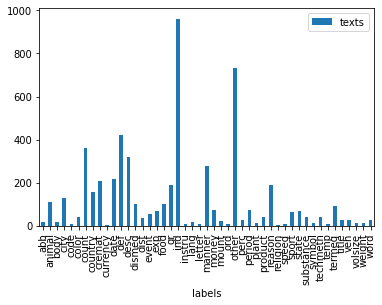

In [3]:
train.groupby('labels').count().plot.bar()

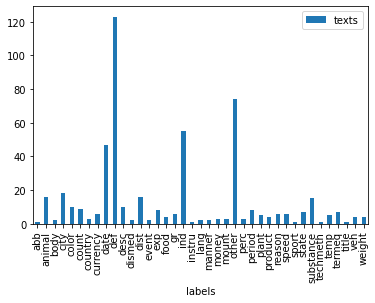

In [4]:
test.groupby('labels').count().plot.bar()

In [5]:
from scipy import stats
import numpy as np
#If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],\
               [i/np.sum(test.groupby('labels').count().values.flatten()) for i in test.groupby('labels').count().values.flatten()])

Ks_2sampResult(statistic=0.21222040370976542, pvalue=0.24282366077934026)

In [0]:
def creat_datasets(n, df):
  n_trains = []
  for i in range(0,df.shape[0],(df.shape[0])//n+1):
    #sample = df.sample((df.shape[0]//n)+1, random_state=i+100)
    sample = df[i:i+(df.shape[0])//n+1]
    n_trains.append(sample)
  return n_trains

train_samples = creat_datasets(1, train)

In [7]:
for sample in train_samples:
  print(stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],[i/np.sum(sample.groupby('labels').count().values.flatten()) for i in sample.groupby('labels').count().values.flatten()]))

Ks_2sampResult(statistic=0.0, pvalue=1.0)


In [0]:
!pip install transformers

In [9]:
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch

def prep_data(sentences, MAX_LEN = 64):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  input_ids = []
  for sent in tqdm(sentences):
      encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
      input_ids.append(encoded_sent[:MAX_LEN])
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  attention_masks = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
  return input_ids, attention_masks

Using TensorFlow backend.


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score

In [0]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
lbls2indx = {lbl:indx for indx, lbl in enumerate(train.labels.unique())}
indx2lbl = {indx:lbl for lbl, indx in lbls2indx.items()}

In [0]:
def lbl2indx(x):
    return lbls2indx[x]

In [0]:
from sklearn.metrics import classification_report

def train_bert(train, test):
  batch_size = 16
  

  print(train.groupby('labels').count().plot.bar())
  print("Labels unique in Train %s - amount:%i" % (train.labels.unique(), len(train.labels.unique())))
  print("Labels unique in Test %s - amount:%i" % (test.labels.unique(), len(test.labels.unique())))
  print(stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],\
               [i/np.sum(test.groupby('labels').count().values.flatten()) for i in test.groupby('labels').count().values.flatten()]))
  
  train['lb'] = train.labels.apply(lbl2indx)
  test['lb'] = test.labels.apply(lbl2indx)


  train_input_ids, train_attention_masks = prep_data(train.texts.values.tolist())
  test_input_ids, test_attention_masks = prep_data(test.texts.values.tolist())

  train_inputs = torch.tensor(train_input_ids)
  validation_inputs = torch.tensor(test_input_ids)

  train_labels = torch.tensor(train.lb.values.tolist())
  validation_labels = torch.tensor(test.lb.values.tolist())

  train_masks = torch.tensor(train_attention_masks)
  validation_masks = torch.tensor(test_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = len(list(lbls2indx.values())), output_attentions = False, output_hidden_states = True)
  model = model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 )
  epochs = 10
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 50, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  device = 'cuda'
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  loss_values = []

  for epoch_i in range(0, epochs):
      embeddings = []

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model.zero_grad()        

          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          loss  = outputs[0]
          embeddings.append(outputs[2][-1][:,0,:])
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      print("")
      print("Running Validation...")

      t0 = time.time()
      test_targets, test_pred_class = [], []

      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          batch = tuple(t.to(device) for t in batch)
          
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():        
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          logits = outputs[0]

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          test_targets.append(label_ids)
          test_pred_class.append(np.argmax(logits, axis=1))
          
          # Calculate the accuracy for this batch of test sentences.          
          # Accumulate the total accuracy.

          nb_eval_steps += 1
      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      f1 = f1_score(test_targets, test_pred_class, average='micro')
      print(classification_report(test_targets, test_pred_class))

      # Report the final accuracy for this validation run.
      print("  F1: {0:.4f}".format(f1))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  return model

Start fitting bert #1
AxesSubplot(0.125,0.125;0.775x0.755)
Labels unique in Train ['manner' 'cremat' 'animal' 'exp' 'ind' 'gr' 'title' 'def' 'date' 'reason'
 'event' 'state' 'desc' 'count' 'other' 'letter' 'religion' 'food'
 'country' 'color' 'termeq' 'city' 'body' 'dismed' 'mount' 'money'
 'product' 'period' 'substance' 'sport' 'plant' 'techmeth' 'volsize'
 'instru' 'abb' 'speed' 'word' 'lang' 'perc' 'code' 'dist' 'temp' 'symbol'
 'ord' 'veh' 'weight' 'currency'] - amount:47
Labels unique in Test ['dist' 'city' 'desc' 'def' 'date' 'gr' 'plant' 'reason' 'ind' 'weight'
 'other' 'substance' 'speed' 'mount' 'temp' 'period' 'count' 'animal'
 'food' 'state' 'termeq' 'money' 'currency' 'country' 'event' 'manner'
 'color' 'product' 'title' 'body' 'veh' 'lang' 'instru' 'abb' 'exp'
 'dismed' 'perc' 'sport' 'techmeth'] - amount:39
Ks_2sampResult(statistic=0.21222040370976542, pvalue=0.24282366077934026)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


 10%|▉         | 544/5452 [00:00<00:00, 5439.34it/s]

100%|██████████| 500/500 [00:00<00:00, 6834.77it/s]




======== Epoch 1 / 10 ========
Training...
  Batch    40  of    341.    Elapsed: 0:00:06.
  Batch    80  of    341.    Elapsed: 0:00:11.
  Batch   120  of    341.    Elapsed: 0:00:16.
  Batch   160  of    341.    Elapsed: 0:00:21.
  Batch   200  of    341.    Elapsed: 0:00:27.
  Batch   240  of    341.    Elapsed: 0:00:32.
  Batch   280  of    341.    Elapsed: 0:00:37.
  Batch   320  of    341.    Elapsed: 0:00:43.

  Average training loss: 2.20
  Training epcoh took: 0:00:45

Running Validation...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.17      1.00      0.29         2
           2       0.86      0.75      0.80        16
           3       0.50      0.12      0.20         8
           4       0.98      1.00      0.99        55
           5       0.83      0.83      0.83         6
           6       0.00      0.00      0.00         1
           7       0.85      0.99      0.91       123
           8       0.92      1.00      0.96        47
           9       1.00      0.83      0.91         6
          10       0.00      0.00      0.00         2
          11       1.00      0.57      0.73         7
          12       0.77      1.00      0.87        10
          13       0.60      1.00      0.75         9
          14       0.60      0.86      0.71        74
          17       0.17      0.75      0.27         4
          18       0.50      1.00      0.67         3
          19       1.00      1.00      1.00        10
          20       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         0
           2       0.76      1.00      0.86        16
           3       0.75      0.75      0.75         8
           4       1.00      1.00      1.00        55
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         1
           7       0.98      0.99      0.98       123
           8       1.00      1.00      1.00        47
           9       1.00      1.00      1.00         6
          10       0.50      0.50      0.50         2
          11       1.00      0.71      0.83         7
          12       0.91      1.00      0.95        10
          13       0.33      1.00      0.50         9
          14       0.78      0.78      0.78        74
          17       0.36      1.00      0.53         4
          18       0.60      1.00      0.75         3
          19       1.00    

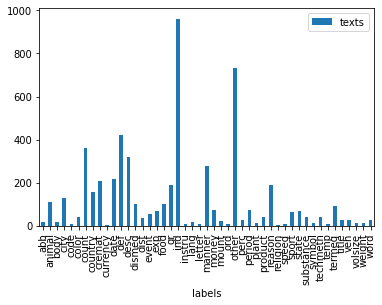

In [15]:
bert_models=[]
for ind,tr_part in enumerate(train_samples):
  print('Start fitting bert #{}'.format(ind+1))
  bert_models.append(train_bert(tr_part,test))


In [34]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [17]:
len(bert_models)

1

In [0]:
from torch import nn
from tqdm import tqdm

def bert_vectors(model, sentences):
  batch_size = 16
  device = "cuda"

  train_input_ids, train_attention_masks = prep_data(sentences)

  train_inputs = torch.tensor(train_input_ids)
  train_labels = torch.tensor([0]*len(sentences))
  train_masks = torch.tensor(train_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

  model.eval()
  augmentations = []
  embeddings = []
  for batch in tqdm(train_dataloader):
      
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      embeddings.append(outputs[2][-1][:,0,:].detach().cpu().numpy())

  embeddings = np.concatenate(embeddings, axis = 0)

  return embeddings

In [22]:
vecs_by_model = []
for i, model in enumerate(bert_models):
  vecs = []
  for set_ in [train, test]:
    vecs.append(bert_vectors(model, set_.texts.tolist()))
  vecs_by_model.append(vecs)

100%|██████████| 32/32 [00:01<00:00, 31.22it/s]


In [24]:
vecs_by_model[0]

[array([[ 0.08376557,  0.4704586 ,  0.06456485, ...,  0.255553  ,
          0.8607259 ,  0.5907866 ],
        [ 0.7994149 , -1.6408968 , -0.6868971 , ...,  0.60354114,
         -0.55077916,  0.3767301 ],
        [-0.13758369,  0.6183139 ,  0.05789348, ...,  0.27732083,
          0.9521697 ,  0.6550751 ],
        ...,
        [-0.6598872 , -0.19653831,  0.30031663, ..., -0.5710405 ,
          0.04656422, -0.7552796 ],
        [-0.5645954 , -0.06290813,  0.38033977, ..., -0.56388384,
         -0.00492774, -0.754871  ],
        [-1.5812547 , -0.2584598 , -0.75631964, ..., -1.0711799 ,
          0.8635152 , -0.556632  ]], dtype=float32),
 array([[ 0.00929285,  0.918753  , -0.38650158, ...,  1.0579802 ,
         -0.9209291 ,  0.31789443],
        [-0.04365676,  0.10205876,  0.51902777, ..., -0.68006766,
         -0.78596807,  0.7100001 ],
        [-0.5700441 ,  0.22879876,  0.62778777, ...,  1.1613637 ,
         -0.6304974 , -0.03528099],
        ...,
        [-0.377725  , -0.8064142 , -0.3

In [25]:
train_vectors = pd.DataFrame({'vecs': [np.array(i) for i in vecs_by_model[0][0].tolist()], 'labels_indx' : train.labels.apply(lbl2indx).tolist()})
test_vectors = pd.DataFrame({'vecs': [np.array(i) for i in vecs_by_model[0][1].tolist()], 'labels_indx' : test.labels.apply(lbl2indx).tolist()})

train_vectors.head()

,vecs,labels_indx
0,"[0.08376556634902954, 0.47045859694480896, 0.0...",0
1,"[0.799414873123169, -1.6408967971801758, -0.68...",1
2,"[-0.1375836879014969, 0.6183139085769653, 0.05...",0
3,"[0.6613439321517944, 0.4035658538341522, -0.66...",2
4,"[0.6701263189315796, -0.24577541649341583, -0....",3


In [0]:
center_of_classes = pd.DataFrame({'vecs': train_vectors.groupby('labels_indx')['vecs'].apply(np.mean).tolist(), 'labels_indx': [i for i in range(len(train.labels.unique()))]})

In [27]:
from scipy.spatial.distance import cosine
distances = []
lbl2center = {i: j for i,j in zip(center_of_classes.labels_indx, center_of_classes.vecs)}
for row in train_vectors.iterrows():
  distances.append(cosine(lbl2center[row[1].labels_indx], row[1].vecs))
train_vectors['distances'] = distances
train_vectors.head()

,vecs,labels_indx,distances
0,"[0.08376556634902954, 0.47045859694480896, 0.0...",0,0.002897
1,"[0.799414873123169, -1.6408967971801758, -0.68...",1,0.006809
2,"[-0.1375836879014969, 0.6183139085769653, 0.05...",0,0.003068
3,"[0.6613439321517944, 0.4035658538341522, -0.66...",2,0.010652
4,"[0.6701263189315796, -0.24577541649341583, -0....",3,0.038200


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


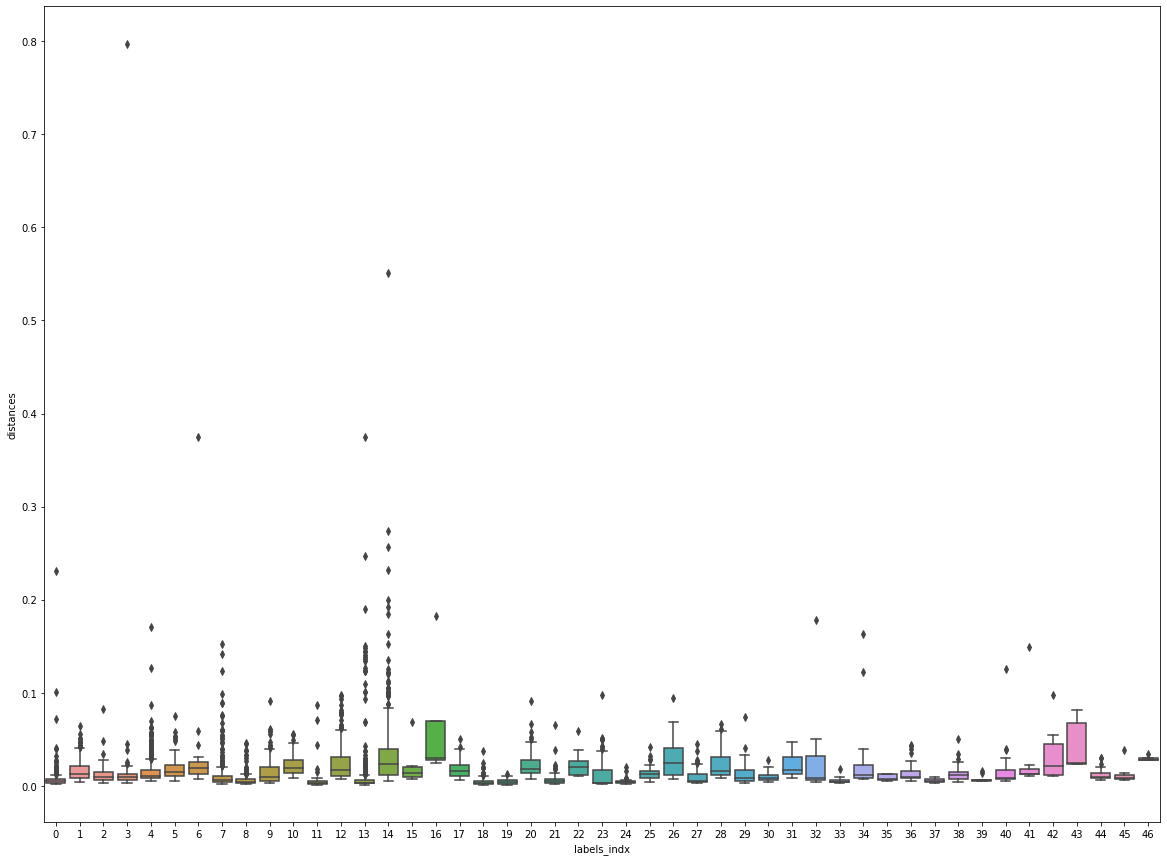

In [28]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20,15))
sns.boxplot(x="labels_indx", y="distances", data=train_vectors)
plt.show()

In [0]:
grouped = train_vectors.groupby('labels_indx')
min_mean_max_mapping = {} 
for name, values in grouped:
  min_mean_max_mapping[name] = {'min': values.distances.min(), 'mean':values.distances.mean(), 'max': values.distances.max(), 'center_emb': values.vecs.mean()}

In [0]:
vectors_with_centers = pd.concat([train_vectors,test_vectors, center_of_classes])

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(vectors_with_centers['vecs'].tolist())

In [0]:
import matplotlib.pyplot as plt
import numpy as np


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

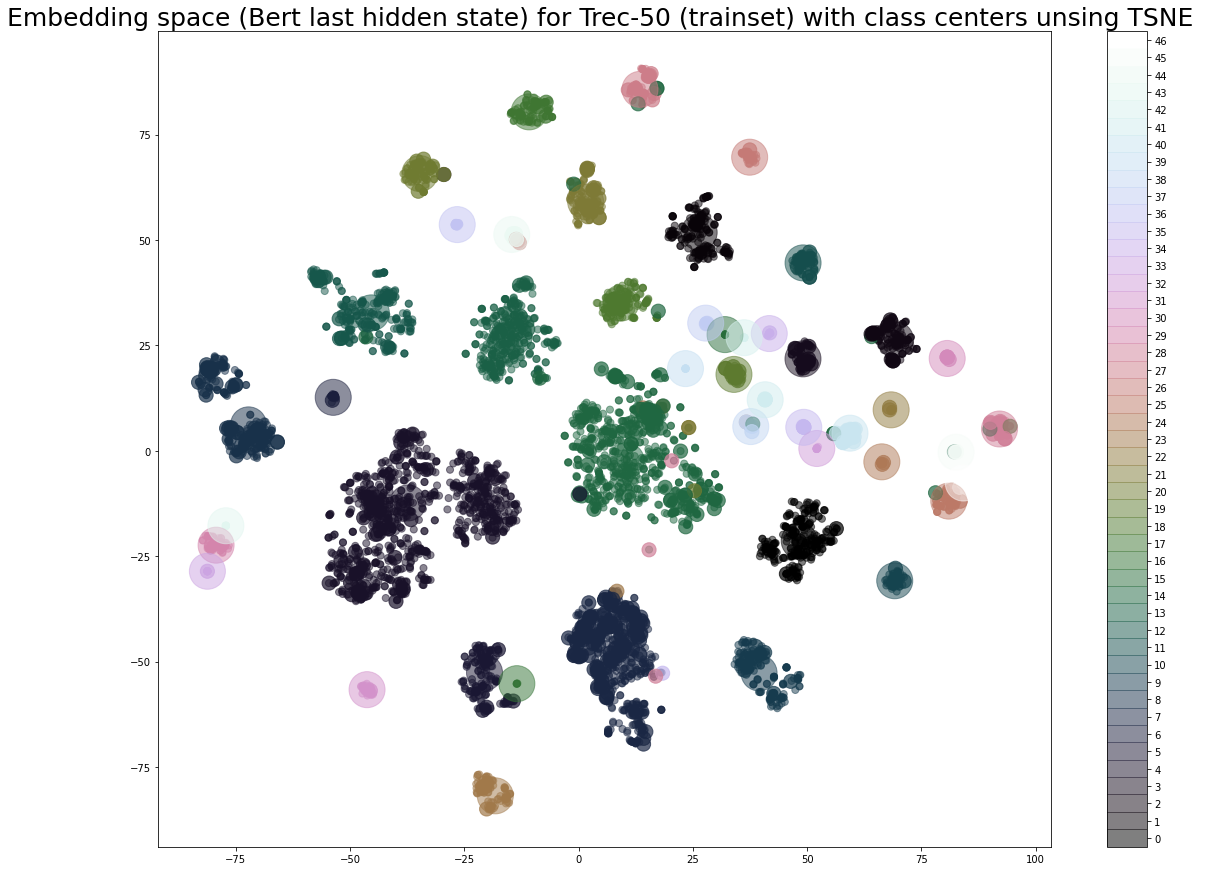

In [38]:
N = len(train.labels.unique())

bounds = train.shape[0], test.shape[0], len(train.labels.unique())

x = [x for x,y in X_embedded][:bounds[0]]
y = [y for x,y in X_embedded][:bounds[0]]
c = vectors_with_centers.labels_indx[:bounds[0]]

x_test = [x for x,y in X_embedded][bounds[0]:bounds[0]+bounds[1]+1]
y_test = [y for x,y in X_embedded][bounds[0]:bounds[0]+bounds[1]+1]
c_test = vectors_with_centers.labels_indx[bounds[0]:bounds[0]+bounds[1]+1]

x_center = [x for x,y in X_embedded][-bounds[2]:]
y_center = [y for x,y in X_embedded][-bounds[2]:]
c_center = vectors_with_centers.labels_indx[-bounds[2]:]
                                                         
plt.figure(figsize=(20,15))
# Edit: don't use the default ('jet') because it makes @mwaskom mad...
plt.scatter(x, y, c=c, s=50, alpha=0.5, cmap=discrete_cmap(N, 'cubehelix'))
plt.scatter(x_test, y_test, c=c_test, s=200, alpha=0.7, cmap=discrete_cmap(N, 'cubehelix'))
plt.scatter(x_center, y_center, c=c_center, s=1300, alpha=0.5, cmap=discrete_cmap(N, 'cubehelix'))
plt.colorbar(ticks=range(N))
plt.title('Embedding space (Bert last hidden state) for Trec-50 (trainset) with class centers unsing TSNE ', {'fontsize': 25})
plt.clim(-0.5, N - 0.5)
plt.show()

In [0]:
from torch import nn
from tqdm import tqdm
def bert_proba(mapping, model, sentences, boundary = 0.5, closer_dist = 'min', longer_dist = 'max', multip = (1,1)):
  batch_size = 16
  device = "cuda"

  train_input_ids, train_attention_masks = prep_data(sentences)

  train_inputs = torch.tensor(train_input_ids)
  train_labels = torch.tensor([0]*len(sentences))
  train_masks = torch.tensor(train_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
  not_sampled = 0
  not_sampled_proba = 0

  model.eval()
  augmentations = []
  for batch in tqdm(train_dataloader):
      
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():        
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

      embedings = outputs[2][-1][:,0,:]
      embedings = embedings.detach().cpu().numpy()
      logits = outputs[1]
      
      probs = nn.Softmax(dim=-1)(logits)
      probs = probs.detach().cpu().numpy()
  
      
      samples = []
      for indx, class_distribution in enumerate(probs.tolist()):
        if any(boundary<prob for prob in class_distribution):
          predicted_class_index = class_distribution.index(max(class_distribution)) #argmax
          sample_emb = embedings[indx]
          predicted_class_center = mapping[predicted_class_index]['center_emb']
          dist = cosine(sample_emb, predicted_class_center)
          if (dist>= mapping[predicted_class_index][closer_dist]*multip[0]) and dist<= (mapping[predicted_class_index][longer_dist]*multip[1]):
            samples.append((indx, predicted_class_index ))
          else:
            not_sampled+=1
        else:
          not_sampled_proba+=1
      augmentations.append(samples)
   
  aug_samples_indx = []
  for ind, i in enumerate(augmentations):
    if ind==0:
      aug_samples_indx.extend([(j,k) for j,k in i])
    else:
      aug_samples_indx.extend([((batch_size*ind)+j, k) for j,k in i])
  print()
  print('Number of samples to look for augmnetations: ', len(sentences) )
  print('Not sampled because of probabilities bound: ', not_sampled_proba)
  print('Not sampled because of vectors distance but proba > {}: {}'.format(boundary, not_sampled))
  print('Number of sampled examples: ', len(aug_samples_indx))
  return aug_samples_indx


# Data augmentations

### wiki

In [0]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def read_wiki(path, n_lines = 10000000):
  lines = open(path).readlines()[:n_lines]
  sentences = []
  for i in lines:
    sentences.extend(sent_tokenize(i)) 
  return sentences


wiki_sentences = read_wiki('wikitext-103/wiki.train.tokens')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### BoolQ

In [0]:
#https://github.com/google-research-datasets/boolean-questions
!wget -O BoolQ_Dataset_train.jsonl https://storage.cloud.google.com/boolq/train.jsonl
!wget -O BoolQ_Dataset_dev.jsonl https://storage.cloud.google.com/boolq/dev.jsonl

--2020-04-23 19:51:27--  https://storage.cloud.google.com/boolq/train.jsonl
Resolving storage.cloud.google.com (storage.cloud.google.com)... 74.125.28.101, 74.125.28.102, 74.125.28.113, ...
Connecting to storage.cloud.google.com (storage.cloud.google.com)|74.125.28.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/boolq/train.jsonl&followup=https://storage.cloud.google.com/boolq/train.jsonl [following]
--2020-04-23 19:51:27--  https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/boolq/train.jsonl&followup=https://storage.cloud.google.com/boolq/train.jsonl
Resolving accounts.google.com (accounts.google.com)... 74.125.195.84, 2607:f8b0:400e:c07::54
Connecting to accounts.google.com (accounts.google.com)|74.125.195.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [0]:
!head BoolQ_Dataset_dev.jsonl


<!DOCTYPE html>
<html lang="en">
  <head>
  <meta charset="utf-8">
  <meta content="width=300, initial-scale=1" name="viewport">
  <meta name="google-site-verification" content="LrdTUW9psUAMbh4Ia074-BPEVmcpBxF6Gwf0MSgQXZs">
  <title>Sign in - Google Accounts</title>
  <style>
  @font-face {


### SQUAD

In [4]:
sq_sents = [i[:-1] for i in open('SQuAD.txt').readlines()]
sq_sents[:10]

['When did Beyonce start becoming popular?',
 'After her second solo album, what other entertainment venture did Beyonce explore?',
 'In her music, what are some recurring elements in them?',
 "Beyonce's younger sibling also sang with her in what band?",
 'What town did Beyonce go to school in?',
 "Who decided to place Beyonce's group in Star Search the talent show?",
 "Which film featured Destiny's Child's first major single?",
 'What mental health issue did Beyonce go through?',
 '"Charlie\'s Angels" featured which single from the band members?',
 'Who did Beyonce star with in the movie, "Austin Powers in Goldmember"?']

### CNN

In [0]:
h0BwmD_VLjROrfTTljRDVZMFJnVWM

# Experiments

In [0]:
def experiment_with_distance(model, sentences, indx2lbl, aug_sent_name, min_mean_max_mapping, boundary, min_b, max_b, coef_min, coef_max):
  print('Prob_boundary: ', boundary)
  print('Minimal distance to the center class: ', min_b)
  print('Max distance to the center class: ', max_b )
  print('Correspinding coefs: {}, {}'.format(coef_min, coef_max))
  augmenations_indexes = bert_proba(min_mean_max_mapping, model, sentences, boundary, min_b, max_b, (coef_min, coef_max) )
  augmetation_sent = pd.DataFrame({"texts":[sentences[i] for i,j in augmenations_indexes], "labels":[indx2lbl[j] for i,j in augmenations_indexes]})
  augmetation_sent.groupby('labels').count().plot.bar()
  augmetation_sent.to_csv('trec50_n1_bert_{}_pr_b-{}_min_b-{}_max_b-{}_coefs{}.csv'.format(aug_sent_name, boundary, min_b, max_b, str(coef_min)+'-'+str(coef_max)))
  return augmetation_sent

In [0]:
0.3 (796,111317), (796,85278), (796,82541), (796,63698), (796,65338), (796,75563), (796,86470), (796,38851), (796,47132), (796,31318), (796,39488), (796,20645), 
0.5 (4334,107864, (4334,81942, (4334,79049, (4334,60398, (4334,61953, (4334,72302, (4334,83769, (4334,36303, (4334,43832, (4334,28259, (4334,36833, (4334,18182

Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 0.5, 0.5


100%|██████████| 8145/8145 [04:33<00:00, 29.76it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 100293
Number of sampled examples:  18121
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 1, 1


100%|██████████| 8145/8145 [04:34<00:00, 29.66it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 74371
Number of sampled examples:  44043
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 2, 2


100%|██████████| 8145/8145 [04:34<00:00, 29.71it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 71499
Number of sampled examples:  46915
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 0.5, 2


100%|██████████| 8145/8145 [04:33<00:00, 29.80it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 52848
Number of sampled examples:  65566
Prob_boundary:  0.75
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 0.5, 0.5


100%|██████████| 8145/8145 [04:32<00:00, 29.87it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 54425
Number of sampled examples:  63989
Prob_boundary:  0.75
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 1, 1


100%|██████████| 8145/8145 [04:33<00:00, 29.76it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 66441
Number of sampled examples:  51973
Prob_boundary:  0.75
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 2, 2


100%|██████████| 8145/8145 [04:33<00:00, 29.83it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 78440
Number of sampled examples:  39974
Prob_boundary:  0.75
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 0.5, 2


100%|██████████| 8145/8145 [04:33<00:00, 29.81it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 30995
Number of sampled examples:  87419
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 0.5, 0.5


100%|██████████| 8145/8145 [04:33<00:00, 29.82it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 36304
Number of sampled examples:  82110
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 1, 1


100%|██████████| 8145/8145 [04:33<00:00, 29.76it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 22398
Number of sampled examples:  96016
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 2, 2


100%|██████████| 8145/8145 [04:34<00:00, 29.72it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 31525
Number of sampled examples:  86889
Prob_boundary:  0.75
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 0.5, 2


100%|██████████| 8145/8145 [04:32<00:00, 29.84it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  11905
Not sampled because of vectors distance but proba > 0.75: 12874
Number of sampled examples:  105540
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 0.5, 0.5


100%|██████████| 8145/8145 [04:32<00:00, 29.91it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 92640
Number of sampled examples:  18086
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 1, 1


100%|██████████| 8145/8145 [04:32<00:00, 29.86it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 66842
Number of sampled examples:  43884
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 2, 2


100%|██████████| 8145/8145 [04:33<00:00, 29.77it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 64048
Number of sampled examples:  46678
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  mean
Correspinding coefs: 0.5, 2


100%|██████████| 8145/8145 [04:32<00:00, 29.90it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 45466
Number of sampled examples:  65260
Prob_boundary:  0.9
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 0.5, 0.5


100%|██████████| 8145/8145 [04:33<00:00, 29.78it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 47106
Number of sampled examples:  63620
Prob_boundary:  0.9
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 1, 1


100%|██████████| 8145/8145 [04:32<00:00, 29.89it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 60942
Number of sampled examples:  49784
Prob_boundary:  0.9
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 2, 2


100%|██████████| 8145/8145 [04:32<00:00, 29.90it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 73024
Number of sampled examples:  37702
Prob_boundary:  0.9
Minimal distance to the center class:  mean
Max distance to the center class:  max
Correspinding coefs: 0.5, 2


100%|██████████| 8145/8145 [04:32<00:00, 29.92it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 25850
Number of sampled examples:  84876
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 0.5, 0.5


100%|██████████| 8145/8145 [04:32<00:00, 29.92it/s]
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 29020
Number of sampled examples:  81706
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 1, 1


100%|██████████| 8145/8145 [04:32<00:00, 29.92it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 17058
Number of sampled examples:  93668
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 2, 2


100%|██████████| 8145/8145 [04:32<00:00, 29.93it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 26346
Number of sampled examples:  84380
Prob_boundary:  0.9
Minimal distance to the center class:  min
Max distance to the center class:  max
Correspinding coefs: 0.5, 2


100%|██████████| 8145/8145 [04:32<00:00, 29.93it/s]



Number of samples to look for augmnetations:  130319
Not sampled because of probabilities bound:  19593
Not sampled because of vectors distance but proba > 0.9: 7764
Number of sampled examples:  102962


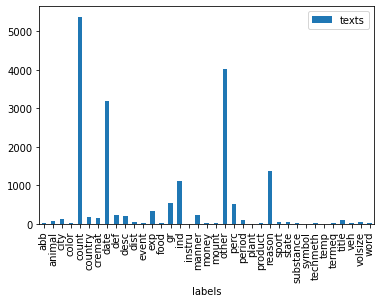

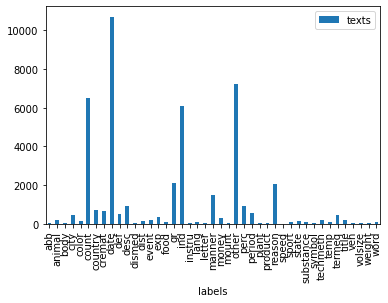

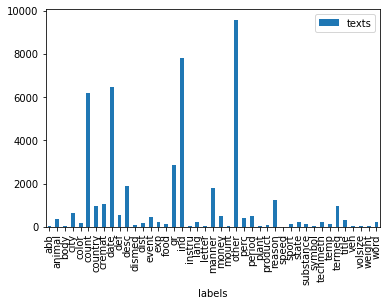

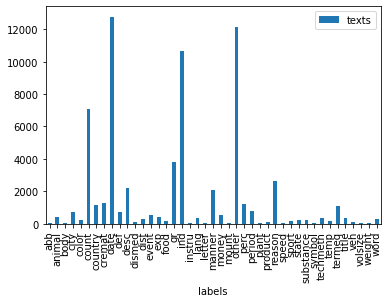

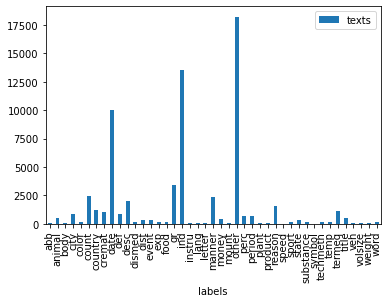

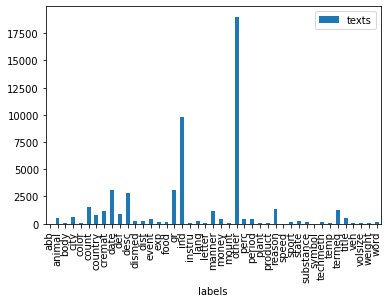

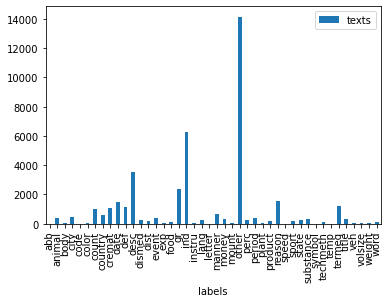

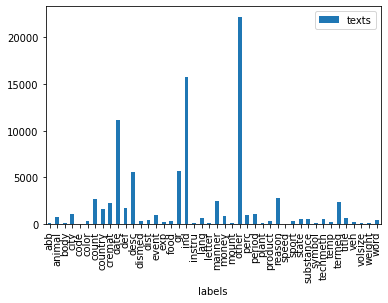

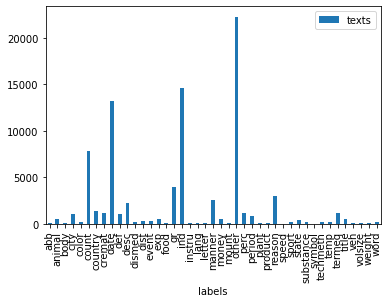

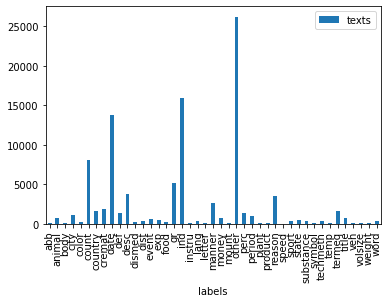

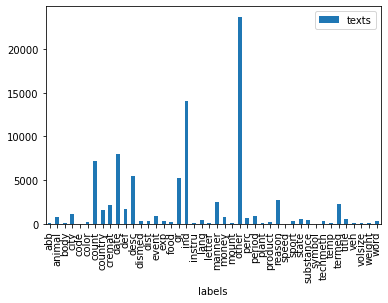

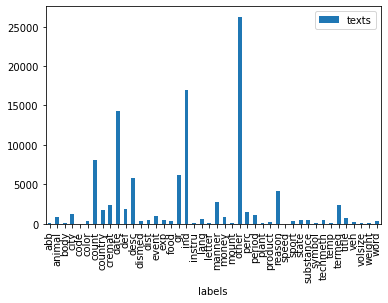

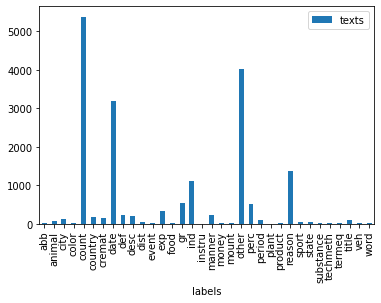

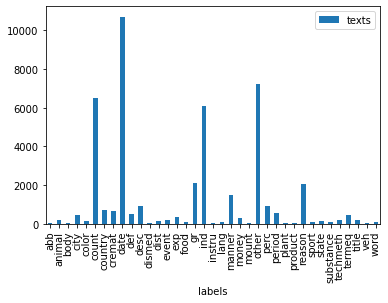

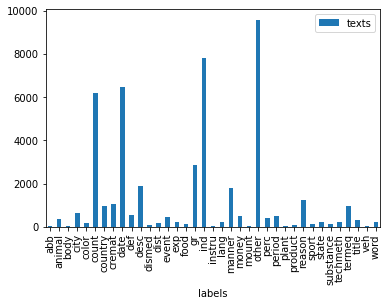

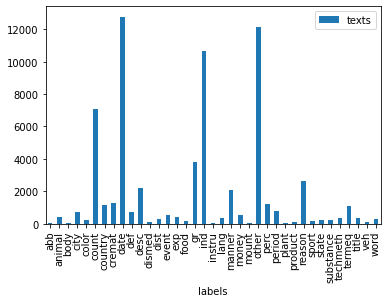

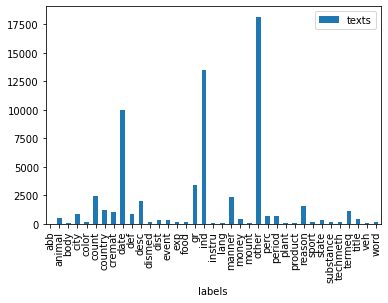

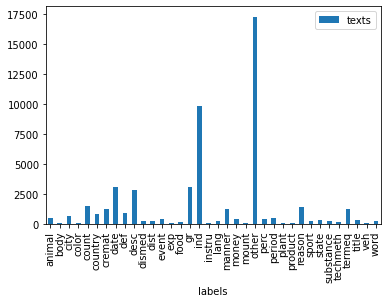

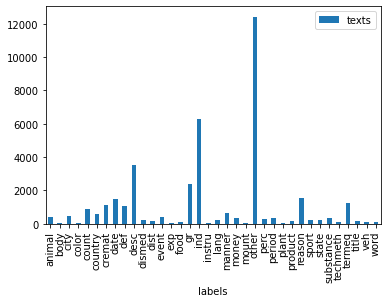

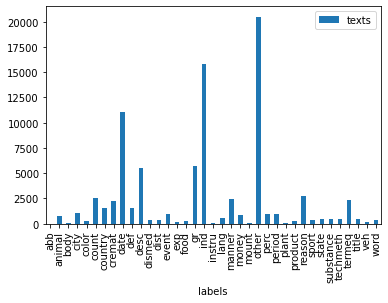

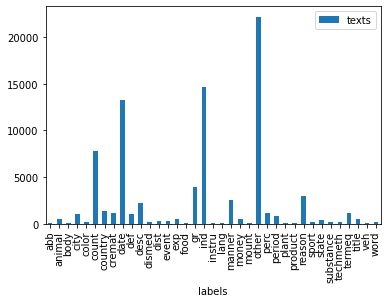

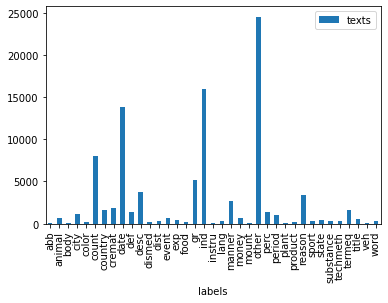

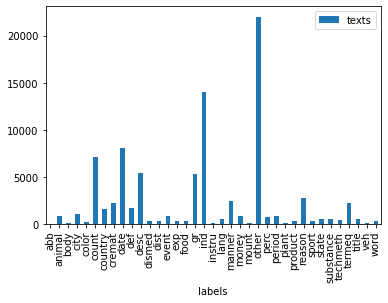

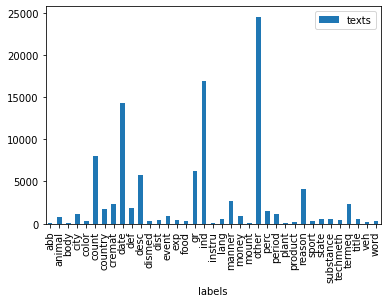

In [49]:
different_augs = []
for i, model in enumerate(bert_models):
  for proba in [0.75, 0.9]:
    for name, sents in {'squad': sq_sents}.items():
      for bs in [('min', 'mean'), ('mean', 'max'), ('min','max')]:
        for coefs in [(0.5, 0.5), (1, 1), (2, 2), (0.5, 2)]:
          different_augs.append(experiment_with_distance(model, sents, indx2lbl, name, min_mean_max_mapping, proba, bs[0], bs[1], coefs[0], coefs[1]))


In [0]:
different_augs = []
for proba in [0.3, 0.5, 0.75, 0.9]:
  for name, sents in {'squad': sq_sents}.items():
    for bs in [('min', 'mean'), ('mean', 'max'), ('min','max')]:
      for coefs in [(0.5, 0.5), (1, 1), (2, 2), (0.5, 2)]:
        different_augs.append(pd.read_csv('trec50_n1_bert_{}_pr_b-{}_min_b-{}_max_b-{}_coefs{}.csv'.format(name, proba, bs[0], bs[1], str(coefs[0])+'-'+str(coefs[1]))))

In [10]:
len(different_augs)

48

In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score
import pandas as pd
from math import sqrt

In [12]:
n_examples = 5000

labels = [i.split(' ', 1 )[0].split(':')[1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
texts = [ i.split(' ', 1 )[1][:-1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
train  = pd.DataFrame({'texts':texts, 'labels': labels})

labels_t = [i.split(' ', 1)[0].split(':')[1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
test  = pd.DataFrame({'texts':texts_t, 'labels': labels_t})
test.shape

(500, 2)

In [0]:
def t(f):
  return lbls2indx[f]
  
class WordData(Dataset):
    
    def __init__(self, x_data, y_data):
        
        super().__init__()
        
        self.x_data = x_data
        self.y_data = torch.LongTensor([int(i) for i in y_data])
        
    
    def __len__(self):
        
        return self.x_data.shape[0]
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx].toarray()
        x = torch.FloatTensor(x)
        y = self.y_data[idx]
        
        return x, y

In [0]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, inner_features2, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        gl = sqrt(6./(in_features+inner_features))
        self.linear_1.weight.data.uniform_(-gl, gl)
        self.non_linear_function = torch.nn.ReLU()
        self.drop_out = torch.nn.Dropout(0.18)
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=inner_features2)
        gl1 = sqrt(6./(inner_features+inner_features2))
        self.linear_2.weight.data.uniform_(-gl1, gl1)
        self.non_linear_function2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=inner_features2, out_features=out_features)
        gl2 = sqrt(6./(inner_features2+out_features))
        self.linear_3.weight.data.uniform_(-gl2, gl2)
  
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.drop_out(x)
        x = self.linear_2(x)
        x = self.non_linear_function2(x)
        x = self.linear_3(x)
        
        return x

In [0]:
import torch
torch.manual_seed(0)
np.random.seed(0)

In [0]:
def train_base_model(train_data, test_data):
  train_data['lb'] = train_data.labels.apply(t)
  test_data['lb'] = test_data.labels.apply(t)
  tf = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_df =0.98, min_df = 3)
  tf_res = tf.fit_transform(train_data.texts)
  test_transform = tf.transform(test_data.texts)
  print('vector space after tf - shape : ', tf_res.shape)

  dataset_train = WordData(tf_res, train_data.lb)
  dataset_test = WordData(test_transform, test.lb)

  batch_size = 256

  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  shuffle=True)
  validation_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

  model = MLP(in_features=tf_res.shape[1], inner_features=524, inner_features2=256, out_features=len(set(train_data.lb.unique())))
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005,  betas=(0.9, 0.999) )
  # aka loss function
  criterion = torch.nn.CrossEntropyLoss()
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = model.to(device)

  epochs = 35
  losses = []
  best_test_loss = 10.
  best_f1 = 0
  best_acc = 0

  test_f1 = []

  for n_epoch in range(epochs):
      
      train_losses = []
      test_losses = []
      test_targets = []
      test_pred_class = []
      
      progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
      
      model.train()
      
      for x, y in train_loader:
          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()

          pred = model(x).squeeze(1)
          loss = criterion(pred, y)
          
          loss.backward()
          
          optimizer.step()
          
          train_losses.append(loss.item())
          losses.append(loss.item())
          
          progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

          progress_bar.update(x.shape[0])
          
      progress_bar.close()
      
      model.eval()
      
      for x, y in validation_loader:     
          
          x = x.to(device)
          y = y.to(device)
        

          with torch.no_grad():
              pred = model(x).squeeze(1)

              pred = pred.cpu()
              y = y.cpu()

              test_targets.append(y.numpy())
              test_pred_class.append(np.argmax(pred, axis=1))

              loss = criterion(pred, y)

              test_losses.append(loss.item())
          
      mean_test_loss = np.mean(test_losses)

      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()


      f1 = f1_score(test_targets, test_pred_class, average='micro')
      acc = accuracy_score(test_targets, test_pred_class)

      if f1>best_f1:
        best_f1=f1
      if acc>best_acc:
        best_acc=acc

      test_f1.append(f1)
      
      print()
      print('Losses: train - {:.7f}, test - {:.7f}'.format(np.mean(train_losses), mean_test_loss))

      print('F1 test - {:.4f}'.format(f1))
          
      # Early stopping:
      if mean_test_loss < best_test_loss:
          best_test_loss = mean_test_loss
      else:
          print('Early stopping')
          break
  return best_f1, best_acc

In [48]:
data_augs_params = [] 
for proba in [0.75, 0.9]:
  for bs in [('min', 'mean'), ('mean', 'max'), ('min','max')]:
    for coefs in [(0.5, 0.5), (1, 1), (2, 2), (0.5, 2)]:
      name = 'Proba: '+str(proba)+' Distance: '+bs[0]+'*'+str(coefs[0])+','+bs[1]+'*'+str(coefs[1])
      data_augs_params.append(name)
data_augs_params

Epoch 6:  94%|█████████▍| 21760/23147 [1:40:34<06:24,  3.61it/s, train_loss=0.41]


['Proba: 0.75 Distance: min*0.5,mean*0.5',
 'Proba: 0.75 Distance: min*1,mean*1',
 'Proba: 0.75 Distance: min*2,mean*2',
 'Proba: 0.75 Distance: min*0.5,mean*2',
 'Proba: 0.75 Distance: mean*0.5,max*0.5',
 'Proba: 0.75 Distance: mean*1,max*1',
 'Proba: 0.75 Distance: mean*2,max*2',
 'Proba: 0.75 Distance: mean*0.5,max*2',
 'Proba: 0.75 Distance: min*0.5,max*0.5',
 'Proba: 0.75 Distance: min*1,max*1',
 'Proba: 0.75 Distance: min*2,max*2',
 'Proba: 0.75 Distance: min*0.5,max*2',
 'Proba: 0.9 Distance: min*0.5,mean*0.5',
 'Proba: 0.9 Distance: min*1,mean*1',
 'Proba: 0.9 Distance: min*2,mean*2',
 'Proba: 0.9 Distance: min*0.5,mean*2',
 'Proba: 0.9 Distance: mean*0.5,max*0.5',
 'Proba: 0.9 Distance: mean*1,max*1',
 'Proba: 0.9 Distance: mean*2,max*2',
 'Proba: 0.9 Distance: mean*0.5,max*2',
 'Proba: 0.9 Distance: min*0.5,max*0.5',
 'Proba: 0.9 Distance: min*1,max*1',
 'Proba: 0.9 Distance: min*2,max*2',
 'Proba: 0.9 Distance: min*0.5,max*2']

In [0]:
result = []
for i,data_additional in enumerate(different_augs):
  print()
  print(data_augs_params[i])
  new_train = pd.concat([data_additional, train])
  new_train = new_train.drop_duplicates()
  new_train = train
  f1, acc = train_base_model(new_train, test)
  result.append((f1, acc))
  print()
  print()

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
result_first_part = [(0.792, 0.792), (0.832, 0.832), (0.838, 0.838), (0.842, 0.842), (0.828, 0.828), (0.8399999999999999, 0.84), (0.81, 0.81), (0.854, 0.854), (0.83, 0.83), (0.85, 0.85), (0.834, 0.834), (0.844, 0.844), (0.79, 0.79), (0.82, 0.82), (0.828, 0.828), (0.8399999999999999, 0.84), (0.836, 0.836), (0.838, 0.838), (0.8119999999999999, 0.812), (0.856, 0.856), (0.832, 0.832), (0.836, 0.836), (0.8399999999999999, 0.84), (0.858, 0.858)]
result_second_part = [(0.78, 0.78), (0.822, 0.822), (0.836, 0.836), (0.838, 0.838), (0.832, 0.832), (0.8399999999999999, 0.84), (0.802, 0.802), (0.85, 0.85), (0.83, 0.83), (0.844, 0.844), (0.85, 0.85), (0.852, 0.852), (0.78, 0.78), (0.816, 0.816), (0.8119999999999999, 0.812), (0.824, 0.824), (0.81, 0.81), (0.8140000000000001, 0.814), (0.804, 0.804), (0.836, 0.836), (0.822, 0.822), (0.83, 0.83), (0.834, 0.834), (0.832, 0.832)]

In [0]:
result = result_first_part + result_second_part

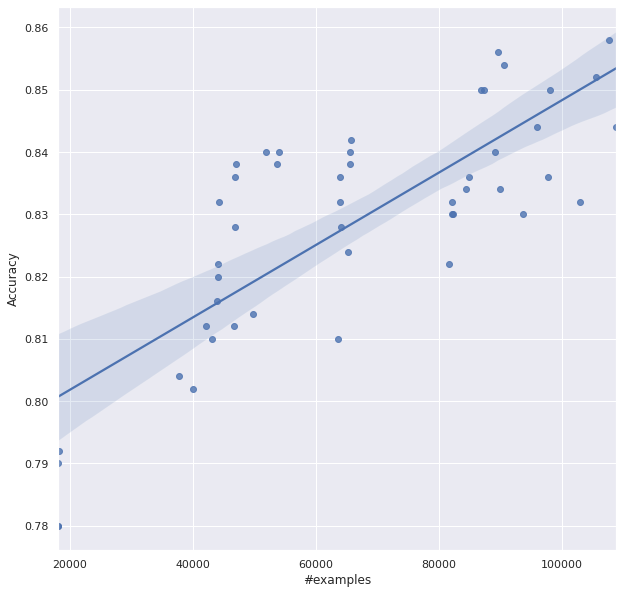

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.figure(figsize=(10,10))
data = pd.DataFrame({'#examples':[x.shape[0] for x in different_augs], 'Accuracy':[j for i, j in result]})
sns.regplot(x="#examples", y="Accuracy", data=data);
plt.show()

In [59]:
data_augs_params = [] 
for proba in [0.3, 0.5, 0.75, 0.9]:
  for bs in [('min', 'mean'), ('mean', 'max'), ('min','max')]:
    for coefs in [(0.5, 0.5), (1, 1), (2, 2), (0.5, 2)]:
      name = 'Proba: '+str(proba)+' Distance: '+bs[0]+'*'+str(coefs[0])+','+bs[1]+'*'+str(coefs[1])
      data_augs_params.append(name)
data_augs_params

['Proba: 0.3 Distance: min*0.5,mean*0.5',
 'Proba: 0.3 Distance: min*1,mean*1',
 'Proba: 0.3 Distance: min*2,mean*2',
 'Proba: 0.3 Distance: min*0.5,mean*2',
 'Proba: 0.3 Distance: mean*0.5,max*0.5',
 'Proba: 0.3 Distance: mean*1,max*1',
 'Proba: 0.3 Distance: mean*2,max*2',
 'Proba: 0.3 Distance: mean*0.5,max*2',
 'Proba: 0.3 Distance: min*0.5,max*0.5',
 'Proba: 0.3 Distance: min*1,max*1',
 'Proba: 0.3 Distance: min*2,max*2',
 'Proba: 0.3 Distance: min*0.5,max*2',
 'Proba: 0.5 Distance: min*0.5,mean*0.5',
 'Proba: 0.5 Distance: min*1,mean*1',
 'Proba: 0.5 Distance: min*2,mean*2',
 'Proba: 0.5 Distance: min*0.5,mean*2',
 'Proba: 0.5 Distance: mean*0.5,max*0.5',
 'Proba: 0.5 Distance: mean*1,max*1',
 'Proba: 0.5 Distance: mean*2,max*2',
 'Proba: 0.5 Distance: mean*0.5,max*2',
 'Proba: 0.5 Distance: min*0.5,max*0.5',
 'Proba: 0.5 Distance: min*1,max*1',
 'Proba: 0.5 Distance: min*2,max*2',
 'Proba: 0.5 Distance: min*0.5,max*2',
 'Proba: 0.75 Distance: min*0.5,mean*0.5',
 'Proba: 0.75 Dis

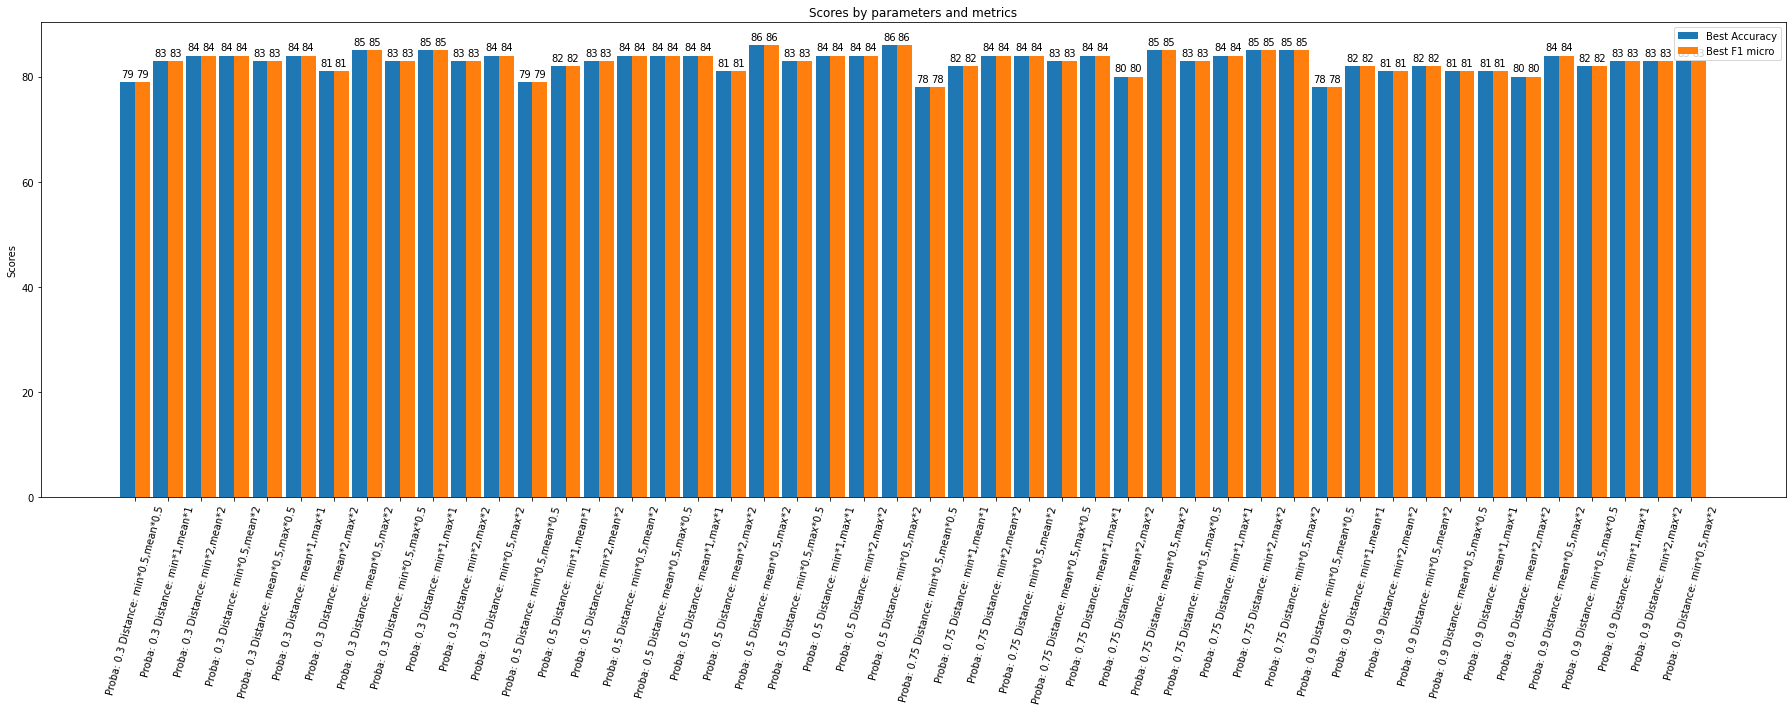

In [64]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = data_augs_params
accs = [round(i*100) for j, i in result]
f1 = [round(j*100) for j, i in result]

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(x - width/2, accs, width, label='Best Accuracy')
rects2 = ax.bar(x + width/2, f1, width, label='Best F1 micro')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by parameters and metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 75)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

plt.show()